# Defining, Training, and Testing Models - Regression

![ml workflow](https://docs.google.com/drawings/d/e/2PACX-1vQ1XLwesZbm_TuDBPFRvbHa4XcjucvtExy3LXE05WnaAw-s6BDVQnnd4lAEUW1Qy6bs6FythuJdFVqP/pub?w=1165&h=662)

Now that we know how to deal with a few types of data, let's start figuring out how we can define, train, and test models in Go. As discussed in the intro to this workshop, there are various types of machine learning (regression, classification, clustering, etc.), but we are going to start with **Regression**.

![linear regression](https://raw.githubusercontent.com/ardanlabs/gotraining/master/topics/data/regression/regression.gif)

In particular, **linear regression** is widely used to model continuous variables and is used as the basis for other models. It also produces models that are immediately interpretable. Thus, linear regression can provide an excellent starting point for learning ML techniques and for introducing predictive capabilities in a organization.

In this example we will be working with a basketball dataset including heights, weights, and ages of various basketball players. To see how linear regression works, we will try to make a prediction of a player's weight based on his height (which should be proportional, right?). In preparation for making that prediction, we will first import our data, profile our data, and split our data into training/test sets.

## Imports

In [1]:
import (
    "io/ioutil"
    "fmt"
    "os"
    "image/color"
    "math"
    
    "github.com/kniren/gota/dataframe"
    "gonum.org/v1/plot"
    "gonum.org/v1/plot/plotter"
    "gonum.org/v1/plot/plotutil"
    "gonum.org/v1/plot/vg"
    "gonum.org/v1/gonum/stat"
)

## Convenience Functions

In [2]:
// GetGraph returns the bytes corresponding to a
// saved plot.
func GetGraph(graphName string) ([]byte, error) {
    
    // Open the file.
    infile, err := os.Open(graphName)
    if err != nil {
        return nil, err
    }
    
    // Read in the contents of the file.
    bytes, err := ioutil.ReadAll(infile)
    if err != nil {
        return nil, err
    }
    
    // Close the file.
    infile.Close()
    
    return bytes, err
}

## Import the Data

In [3]:
// Open the data file.
f, err := os.Open("../data/basketball.heigh.and.weigh.csv")
if err != nil {
    fmt.Println(err)
}

// Read in the contents to a dataframe.
dataset := dataframe.ReadCSV(f)

// Close the file.
f.Close()

In [4]:
// Output a summary of the dataset to stdout.
fmt.Println(dataset)

[1034x6] DataFrame

    Name            Team     Position       Height(inches) Weight(pounds) ...
 0: Adam_Donachie   BAL      Catcher        74             180            ...
 1: Paul_Bako       BAL      Catcher        74             215            ...
 2: Ramon_Hernandez BAL      Catcher        72             210            ...
 3: Kevin_Millar    BAL      First_Baseman  72             210            ...
 4: Chris_Gomez     BAL      First_Baseman  73             188            ...
 5: Brian_Roberts   BAL      Second_Baseman 69             176            ...
 6: Miguel_Tejada   BAL      Shortstop      69             209            ...
 7: Melvin_Mora     BAL      Third_Baseman  71             200            ...
 8: Aubrey_Huff     BAL      Third_Baseman  76             231            ...
 9: Adam_Stern      BAL      Outfielder     71             180            ...
    ...             ...      ...            ...            ...            ...
    <string>        <string> <string>       

1061 <nil>

## Profile our data set

### Distribution of numerical features

For each team, let's get a sense of the measure of centrality and dispersion. That is, let's look at how the data is distributed in the various numerical columns of the data set. We can use the `Describe()` method to do this for all the numerical columns simultaneously. 

In [5]:
// Select the numeric columns and call the Describe method.
fmt.Println(dataset.Select([]string{"Height(inches)", "Weight(pounds)", "Age"}).Describe())

[7x4] DataFrame

    column   Height(inches) Weight(pounds) Age      
 0: mean     73.697292      201.494197     28.736712
 1: stddev   2.305818       21.898792      4.320310 
 2: min      67.000000      0.000000       20.900000
 3: 25%      72.000000      187.000000     25.440000
 4: 50%      74.000000      200.000000     27.920000
 5: 75%      75.000000      215.000000     31.240000
 6: max      83.000000      290.000000     48.520000
    <string> <float>        <float>        <float>  



495 <nil>

In [6]:
// Create a []string value to hold the names of plots we are going to create.
var plotNames []string

// Create a histogram for each of the numeric columns in the dataset.
for _, colName := range dataset.Select([]string{"Height(inches)", "Weight(pounds)", "Age"}).Names() {

    // Create a plotter.Values value and fill it with the
    // values from the respective column of the dataframe.
    plotVals := make(plotter.Values, dataset.Nrow())
    for i, floatVal := range dataset.Col(colName).Float() {
        plotVals[i] = floatVal
    }

    // Make a plot and set its title.
    p, err := plot.New()
    if err != nil {
        fmt.Println(err)
    }
    p.Title.Text = fmt.Sprintf("Histogram of a %s", colName)

    // Create a histogram of our values drawn
    // from the standard normal.
    h, err := plotter.NewHist(plotVals, 16)
    if err != nil {
        fmt.Println(err)
    }

    // Normalize the histogram.
    h.Normalize(1)

    // Add the histogram to the plot.
    p.Add(h)

    // Save the plot to a PNG file.
    if err := p.Save(4*vg.Inch, 4*vg.Inch, colName+"_hist.png"); err != nil {
        fmt.Println(err)
    }
    
    // Add the name to the plot names.
    plotNames = append(plotNames, colName+"_hist.png")
}

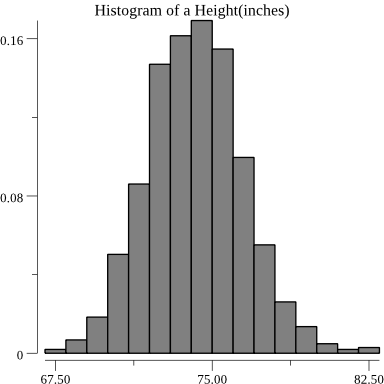

In [7]:
// Read the plot data from the first histogram.
plotBytes, err := GetGraph(plotNames[0])
if err != nil {
    fmt.Println(err)
}
    
// Display the plot.
display.PNG(plotBytes)

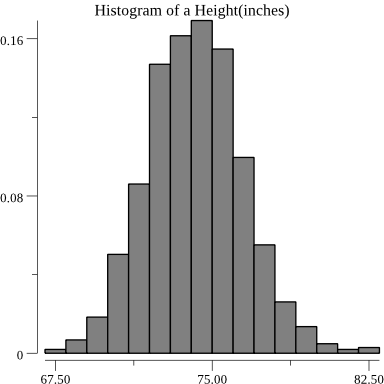

In [8]:
// Read the plot data from the second histogram.
plotBytes, err := GetGraph(plotNames[0])
if err != nil {
    fmt.Println(err)
}
    
// Display the plot.
display.PNG(plotBytes)

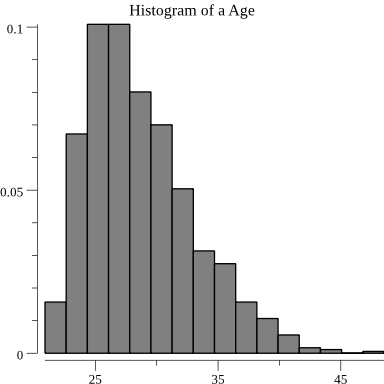

In [9]:
// Read the plot data from the third histogram.
plotBytes, err := GetGraph(plotNames[2])
if err != nil {
    fmt.Println(err)
}
    
// Display the plot.
display.PNG(plotBytes)

### Correlations between width and height

In linear regression we make a few assumptions. Among a few other things (which we won't dive into here), we assume:

- normality of the data (those distributions above should look similar to a bell curve)
- linear correlation between the response and the feature(s)

We can roughly test the first condition via the plots above, but we haven't yet determined if there actually is a linear relationship between our feature (height) and our response (weight). To do that, we can plot height vs. weight using a scatter plot.

In [10]:
// Define a new plot.
plotGrid, err := plot.New()
if err != nil {
    fmt.Println(err)
}

// Label our plot.
plotGrid.Title.Text = "weight vs. height"
plotGrid.Y.Label.Text = "Weight"
plotGrid.X.Label.Text = "Height"
plotGrid.Add(plotter.NewGrid())

In [11]:
// pts will hold the values for plotting.
pts := make(plotter.XYs, dataset.Nrow())

// Extract the weight column.
yVals := dataset.Col("Weight(pounds)").Float()

// Fill pts with the height and weight data.
for i, floatVal := range dataset.Col("Height(inches)").Float() {
    pts[i].X = floatVal
    pts[i].Y = yVals[i]
}

In [12]:
// Create the scatter plot.
s, err := plotter.NewScatter(pts)
if err != nil {
    fmt.Println(err)
}

// Pick the scatter plot colors
s.GlyphStyle.Color = color.RGBA{R: 255, B: 128, A: 255}

// Add the scatter plot to the plot.
plotGrid.Add(s)

// Save the plot to a file.
if err := plotGrid.Save(4*vg.Inch, 4*vg.Inch, "weight_vs_height.png"); err != nil {
    fmt.Println(err)
}

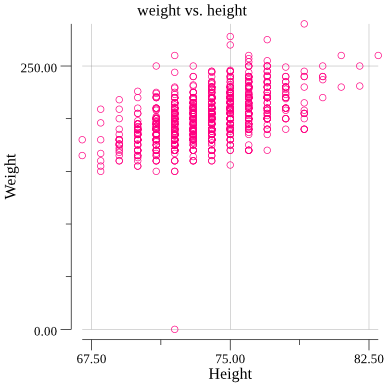

In [13]:
// Display the scatter plot.
splot, err := GetGraph("weight_vs_height.png")
if err != nil {
    fmt.Println(err)
}
display.PNG(splot)

## Split our data into training and test data

Being able to properly **evaluate** a model is essential. Without evaluation, the model development process is just guess work. Evaluation helps us find the best model to make a prediction and gives us an idea about how the model should perform in the future. A whole variety of evaluation metrics have been developed and not all evaluation metrics are relevant to all models. We will explore a sampling of these metrics/scores in the workshop, but it is very important to evaluate the metrics/scores you are using on a case by case basis.

It is also important that you don't "train" or "fit" your model on the same data that is utilized in evaluation or testing. If you do this, you are in danger of overfitting. To avoid this outcome, we will split our data into a training data set and a test data set. We will fit our linear regression model on the **training data set** and we will evaluate it, using an evaluation metric, on the **test data set**.

In [14]:
// Calculate the number of elements in each set.
// We will utilize and 80/20 split in this case.
trainingNum := (4 * dataset.Nrow()) / 5
testNum := dataset.Nrow() / 5
if trainingNum+testNum < dataset.Nrow() {
    trainingNum++
}

// Create the subset indices.
trainingIdx := make([]int, trainingNum)
testIdx := make([]int, testNum)

// Enumerate the training indices.
for i := 0; i < trainingNum; i++ {
    trainingIdx[i] = i
}

// Enumerate the test indices.
for i := 0; i < testNum; i++ {
    testIdx[i] = trainingNum + i
}

// Create the subset dataframes.
trainingDF := dataset.Subset(trainingIdx)
testDF := dataset.Subset(testIdx)

In [15]:
// Output the sizes of our training and test sets.
fmt.Println(trainingDF.Nrow())
fmt.Println(testDF.Nrow())

828
206


4 <nil>

## Training our model on the training data

We will now "train" a linear regression model on the training data set. When we say train, we mean that we will find the ideal parameters of the linear regression model that model the relationship represented in our data. In this case, we will be modeling weight (our response) by height (our feature). Because we are using linear regression, we are modeling this like a line:

```
weight = alpha + beta * height
```

and "training" consists of finding `alpha` and `beta`. Thankfully there are a couple of really handy Go packages that will perform this training for us. One of them is `gonum.org/v1/gonum/stat`. 

In [16]:
// Find alpha and beta using gonum's stat package.
alpha, beta := stat.LinearRegression(trainingDF.Col("Height(inches)").Float(), trainingDF.Col("Weight(pounds)").Float(), nil, false)

// Output alpha and beta to stdout.
fmt.Printf("weight = %f + %f * height", alpha, beta) 

weight = -163.073097 + 4.941490 * height

40 <nil>

## Evaluating our model on the test data

As mentioned there are a variety of evaluation metrics that can be used to evaluate the performance of our model (or any regression model). A few typical ones are:

- Mean Absolute Error (MAE) - the average of the absolute differences between all of observation-prediction pairs. 
- Root Mean Squared Error (RMSE) - the square root of the average of the squared differences between all of observation-prediction pairs.
- R Squared (aka the Coefficient of Determination) - the percentage of the variance in the observations captured by the predictions. 

Let's try using RMSE in this case. 

In [17]:
// Define a function that will utilize our "trained" model
// to make predictions.
func predict(height float64) float64 {
    return alpha + beta * height
}

In [18]:
// Extract the observed weights and test height values.
observed := testDF.Col("Weight(pounds)").Float()
testHeights := testDF.Col("Height(inches)").Float()

// Calculate the mean squared error.
var mSE float64
for idx, oVal := range observed {
    mSE += math.Pow(oVal-predict(testHeights[idx]), 2) / float64(len(observed))
}

// Calcualte the RMSE.
rMSE := math.Sqrt(mSE)

// Output the result to stdout.
fmt.Printf("RMSE: %f", rMSE)

RMSE: 17.058650

15 <nil>